In [3]:
from pathlib import Path
import pandas as pd
from settings import PROCESSED_DATA_DIR
from reduce_memory_usage import reduce_memory_usage

matches_df = pd.read_csv(Path(PROCESSED_DATA_DIR, 'bundesliga_matches.csv'))

# matches_df = reduce_memory_usage(matches_df)

In [4]:
from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestClassifier


def make_predictions(data, cutoff_date='2023-04-01'):
    """
    Make predictions using the random forest classifier.

    :param data: the dataframe to use
    :param cutoff_date: the date to use for splitting the data into train and test sets
    :return: combined: a dataframe containing the actual and predicted values
    """
    # Pick the predictor columns.
    predictors = [c for c in matches_df.columns if c.startswith('feat_')]

    # Split the data into train and test sets.
    train_set = data[data['info_date'] < cutoff_date]
    test_set = data[data['info_date'] >= cutoff_date]
    print(f'Train: {len(train_set)} matches ({len(train_set) / len(data):.2%})')
    print(f'Test: {len(test_set)} matches ({len(test_set) / len(data):.2%})')

    # Create and fit (train) the model.
    model = RandomForestClassifier(
        n_estimators=50,  # number of trees in the forest
        min_samples_split=10,  # number of samples required to split an internal node
        random_state=1  # seed
    )
    model.fit(train_set[predictors], train_set['target'])

    # Make predictions on the test dataset and calculate the precision score.
    predictions = model.predict(test_set[predictors])
    precision = precision_score(test_set['target'], predictions)
    print(f'Precision: {precision:.2%}')

    # Create a dataframe containing the actual and predicted values.
    combined = pd.DataFrame(
        dict(actual=test_set['target'], prediction=predictions),
        index=test_set.index
    )
    return combined

In [5]:
combined = make_predictions(matches_df, cutoff_date='2023-10-01')

Train: 3695 matches (97.52%)
Test: 94 matches (2.48%)
Precision: 76.47%


In [6]:
def pick_confident_matches(df):
    merged = combined.merge(combined, left_on=['info_date', 'info_team'], right_on=['info_date', 'info_opponent'])
    high_confidence_matches_df = df[(merged['prediction_x'] == 1) & (df['prediction_y'] == 0)]
    precision_df = high_confidence_matches_df['actual_x'].value_counts()
    precision = precision_df.iloc[0] / (precision_df.iloc[0] + precision_df.iloc[1]) * 100
    print(f'Precision: {precision:.2f}%')
    return high_confidence_matches_df

In [7]:
combined = combined.merge(
    matches_df,
    left_index=True,
    right_index=True
)

In [8]:
combined.insert(0,'key','')
combined['key'] = combined.apply(
    lambda x: f"{x['info_date']}_{x['info_team']}_{x['info_opponent']}" if x['info_venue'] == 'Home' else f"{x['info_date']}_{x['info_opponent']}_{x['info_team']}",
    axis=1
)
combined.head()

,key,actual,prediction,feat_gf_rolling_avg,feat_ga_rolling_avg,feat_xg_rolling_avg,feat_xga_rolling_avg,feat_poss_rolling_avg,feat_attendance_rolling_avg,feat_shooting_standard_sh_rolling_avg,...,feat_opponent_code,feat_venue_code,feat_hour,feat_day_code,feat_month_code,target,info_date,info_team,info_opponent,info_venue
271,2023-10-01_Freiburg_Augsburg,0,0,1.333333,2.000000,1.466667,1.100000,41.666667,33160.000000,10.666667,...,9,0,17,6,10,0,2023-10-01,Augsburg,Freiburg,Away
272,2023-10-07_Augsburg_Darmstadt 98,0,0,0.666667,2.000000,1.100000,0.900000,44.666667,35063.333333,11.333333,...,5,1,15,5,10,0,2023-10-07,Augsburg,Darmstadt 98,Home
273,2023-10-22_Heidenheim_Augsburg,1,0,1.000000,1.666667,0.833333,1.133333,45.333333,29881.333333,12.000000,...,13,0,17,6,10,1,2023-10-22,Augsburg,Heidenheim,Away
274,2023-10-28_Augsburg_Wolfsburg,1,0,2.000000,2.000000,1.400000,1.433333,45.333333,25778.000000,13.000000,...,26,1,15,5,10,1,2023-10-28,Augsburg,Wolfsburg,Home
275,2023-11-04_Koln_Augsburg,0,0,3.000000,2.000000,1.600000,1.566667,43.000000,24066.666667,11.333333,...,16,0,15,5,11,0,2023-11-04,Augsburg,Koln,Away


In [9]:
from settings import INTERIM_DATA_DIR

odds_df = pd.read_csv(Path(INTERIM_DATA_DIR, 'bundesliga_odds.csv'))

In [10]:
odds_df.insert(0,'key','')
odds_df['key'] = odds_df.apply(
    lambda x: f"{x['date']}_{x['team']}_{x['opponent']}",
    axis=1
)
# drop date, team, opponent columns to not create duplicates when merging
odds_df.drop(columns=['date','team','opponent'], inplace=True)
odds_df.head()

,key,fthg,ftag,ftr,hthg,htag,htr,hs,as,hst,...,bbmx>2.5,bbav>2.5,bbmx<2.5,bbav<2.5,bbah,bbahh,bbmxahh,bbavahh,bbmxaha,bbavaha
0,2022-08-05_Eintracht Frankfurt_Bayern Munich,1,6,A,0,5,A,8,23,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-08-06_Augsburg_Freiburg,0,4,A,0,0,D,10,19,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-08-06_Bochum_Mainz 05,1,2,A,1,1,D,16,13,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-08-06_Monchengladbach_Hoffenheim,3,1,H,1,1,D,18,2,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-08-06_Union Berlin_Hertha BSC,3,1,H,1,0,H,18,9,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
merged_df = pd.merge(combined, odds_df, on='key', how='left')
merged_df.head()

,key,actual,prediction,feat_gf_rolling_avg,feat_ga_rolling_avg,feat_xg_rolling_avg,feat_xga_rolling_avg,feat_poss_rolling_avg,feat_attendance_rolling_avg,feat_shooting_standard_sh_rolling_avg,...,bbmx>2.5,bbav>2.5,bbmx<2.5,bbav<2.5,bbah,bbahh,bbmxahh,bbavahh,bbmxaha,bbavaha
0,2023-10-01_Freiburg_Augsburg,0,0,1.333333,2.000000,1.466667,1.100000,41.666667,33160.000000,10.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-10-07_Augsburg_Darmstadt 98,0,0,0.666667,2.000000,1.100000,0.900000,44.666667,35063.333333,11.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-10-22_Heidenheim_Augsburg,1,0,1.000000,1.666667,0.833333,1.133333,45.333333,29881.333333,12.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-10-28_Augsburg_Wolfsburg,1,0,2.000000,2.000000,1.400000,1.433333,45.333333,25778.000000,13.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-11-04_Koln_Augsburg,0,0,3.000000,2.000000,1.600000,1.566667,43.000000,24066.666667,11.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# order by info_date
merged_df.sort_values(by='info_date', inplace=True)

In [13]:
# create a new column where b365h is multiplied by 5
# for rows where actual = 1 and prediction  = 1
# else write -5

def lam(x, bet=5):
    if x['actual'] == 1 and x['prediction'] == 1:
        if x['info_venue'] == 'Home':
            return x['b365h'] * bet - bet
        else:
            return x['b365a'] * bet - bet
    elif x['actual'] == 0 and x['prediction'] == 1:
        return -bet
    else:
        return 0

merged_df.insert(0,'profit',0)
merged_df['profit'] = merged_df.apply(
    lambda x: lam(x, 10),
    axis=1
)
merged_df.head()

,profit,key,actual,prediction,feat_gf_rolling_avg,feat_ga_rolling_avg,feat_xg_rolling_avg,feat_xga_rolling_avg,feat_poss_rolling_avg,feat_attendance_rolling_avg,...,bbmx>2.5,bbav>2.5,bbmx<2.5,bbav<2.5,bbah,bbahh,bbmxahh,bbavahh,bbmxaha,bbavaha
0,0.0,2023-10-01_Freiburg_Augsburg,0,0,1.333333,2.000000,1.466667,1.100000,41.666667,33160.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83,0.0,2023-10-01_Darmstadt 98_Werder Bremen,0,0,2.666667,1.666667,2.600000,1.333333,50.333333,39305.047093,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37,0.0,2023-10-01_Freiburg_Augsburg,1,0,0.666667,3.000000,0.833333,1.533333,48.333333,48266.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,0.0,2023-10-01_Darmstadt 98_Werder Bremen,1,0,1.666667,3.666667,0.600000,3.000000,35.666667,33821.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,0.0,2023-10-06_Monchengladbach_Mainz 05,0,0,2.000000,1.666667,2.533333,1.200000,50.000000,31310.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


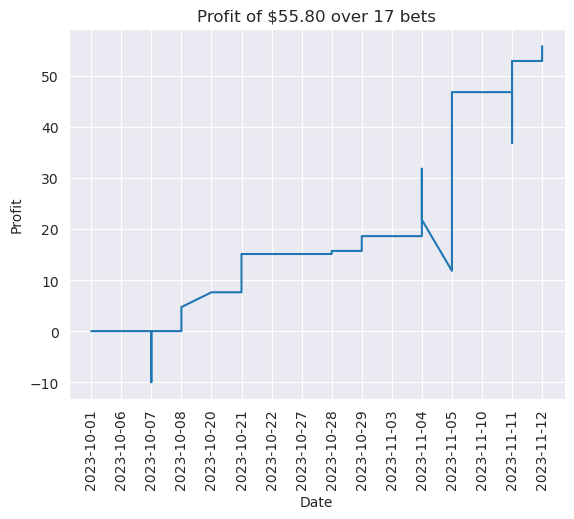

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

bets_placed = merged_df['profit'].ne(0).sum()
profit = merged_df['profit'].sum()

sns.set_style('darkgrid')
plt.plot(merged_df['info_date'], merged_df['profit'].cumsum())
plt.xticks(rotation=90)
plt.title(f'Profit of ${profit:.2f} over {bets_placed} bets')
plt.xlabel('Date')
plt.ylabel('Profit')
plt.show()

## Rerun profitability calculations

In [29]:
# starting from 2020, train the model on data before 2020 and test on data 10 days after that
# then reiterate going 10 days forward

def make_predictions(data, cutoff_date='2023-04-01'):
    """
    Make predictions using the random forest classifier.

    :param data: the dataframe to use
    :param cutoff_date: the date to use for splitting the data into train and test sets
    :return: combined: a dataframe containing the actual and predicted values
    """
    # Pick the predictor columns.
    predictors = [c for c in matches_df.columns if c.startswith('feat_')]

    test_cutoff_date = pd.to_datetime(cutoff_date) + pd.Timedelta(days=10)
    train_set = data[data['info_date'] < cutoff_date]
    test_set = data[(data['info_date'] >= cutoff_date) & (data['info_date'] < test_cutoff_date.strftime('%Y-%m-%d'))]

    print('From {} to {}'.format(cutoff_date, test_cutoff_date.strftime('%Y-%m-%d')))
    print(f'Train: {len(train_set)} matches ({len(train_set) / len(data):.2%})')
    print(f'Test: {len(test_set)} matches ({len(test_set) / len(data):.2%})')
    
    if len(test_set) == 0 or len(train_set) == 0:
        return None

    # Create and fit (train) the model.
    model = RandomForestClassifier(
        n_estimators=50,  # number of trees in the forest
        min_samples_split=10,  # number of samples required to split an internal node
        random_state=1  # seed
    )
    model.fit(train_set[predictors], train_set['target'])

    # Make predictions on the test dataset and calculate the precision score.
    predictions = model.predict(test_set[predictors])
    precision = precision_score(test_set['target'], predictions)
    print(f'Precision: {precision:.2%}')

    # Create a dataframe containing the actual and predicted values.
    combined = pd.DataFrame(
        dict(actual=test_set['target'], prediction=predictions),
        index=test_set.index
    )
    return combined

In [36]:
matches_df = pd.read_csv(Path(PROCESSED_DATA_DIR, 'bundesliga_matches.csv'))
cutoff_date = '2020-01-01'
# create a loop to iterate until cutoff date is 2023-11-01
combines = []
while cutoff_date != '2023-11-01':
    print('-----------------------------------------------')
    copy = matches_df.copy()
    # make predictions
    combined = make_predictions(copy, cutoff_date)
    # if combined is None, break out of loop
    if combined is None:
        cutoff_date = pd.to_datetime(cutoff_date) + pd.Timedelta(days=10)
        cutoff_date = cutoff_date.strftime('%Y-%m-%d')
        continue
    # # merge combined with matches_df
    # matches_df = matches_df.merge(
    #     combined,
    #     left_index=True,
    #     right_index=True
    # )
    combines.append(combined)

    # increment cutoff date by 10 days
    cutoff_date = pd.to_datetime(cutoff_date) + pd.Timedelta(days=10)
    cutoff_date = cutoff_date.strftime('%Y-%m-%d')

-----------------------------------------------
From 2020-01-01 to 2020-01-11
Train: 1464 matches (38.64%)
Test: 0 matches (0.00%)
-----------------------------------------------
From 2020-01-11 to 2020-01-21
Train: 1464 matches (38.64%)
Test: 18 matches (0.48%)
Precision: 100.00%
-----------------------------------------------
From 2020-01-21 to 2020-01-31
Train: 1482 matches (39.11%)
Test: 18 matches (0.48%)
Precision: 80.00%
-----------------------------------------------
From 2020-01-31 to 2020-02-10
Train: 1500 matches (39.59%)
Test: 34 matches (0.90%)
Precision: 42.86%
-----------------------------------------------
From 2020-02-10 to 2020-02-20
Train: 1534 matches (40.49%)
Test: 18 matches (0.48%)
Precision: 100.00%
-----------------------------------------------
From 2020-02-20 to 2020-03-01
Train: 1552 matches (40.96%)
Test: 30 matches (0.79%)
Precision: 75.00%
-----------------------------------------------
From 2020-03-01 to 2020-03-11
Train: 1582 matches (41.75%)
Test: 22 m

In [66]:
# combine all dataframes in combines
combined_df = pd.concat(combines)

matches_df2 = matches_df.copy().merge(
    combined_df,
    left_index=True,
    right_index=True
)

In [67]:
matches_df2 = matches_df2.merge(matches_df2, left_on=['info_date', 'info_team'], right_on=['info_date', 'info_opponent'])

In [68]:
matches_df2.insert(0,'key','')
matches_df2['key'] = matches_df2.apply(
    lambda x: f"{x['info_date']}_{x['info_team_x']}_{x['info_opponent_x']}" if x['info_venue_x'] == 'Home' else f"{x['info_date']}_{x['info_opponent_x']}_{x['info_team_x']}",
    axis=1
)
matches_df2.head()

,key,feat_gf_rolling_avg_x,feat_ga_rolling_avg_x,feat_xg_rolling_avg_x,feat_xga_rolling_avg_x,feat_poss_rolling_avg_x,feat_attendance_rolling_avg_x,feat_shooting_standard_sh_rolling_avg_x,feat_shooting_standard_sot_rolling_avg_x,feat_shooting_standard_sot%_rolling_avg_x,...,feat_venue_code_y,feat_hour_y,feat_day_code_y,feat_month_code_y,target_y,info_team_y,info_opponent_y,info_venue_y,actual_y,prediction_y
0,2020-10-17_Arminia_Bayern Munich,0.666667,0.666667,0.700000,1.366667,49.000000,4086.666667,9.333333,3.333333,35.433333,...,0,18,5,10,1,Bayern Munich,Arminia,Away,1,1
1,2020-10-25_Wolfsburg_Arminia,0.666667,1.666667,0.900000,1.633333,47.666667,39305.047093,9.000000,3.666667,39.500000,...,1,15,6,10,1,Wolfsburg,Arminia,Home,1,0
2,2020-10-31_Arminia_Dortmund,0.666667,2.333333,1.000000,1.900000,49.333333,39305.047093,9.666667,3.333333,33.666667,...,0,15,5,10,1,Dortmund,Arminia,Away,1,1
3,2020-11-07_Union Berlin_Arminia,0.666667,2.666667,0.733333,2.566667,37.000000,39305.047093,8.333333,2.666667,32.200000,...,1,15,5,11,1,Union Berlin,Arminia,Home,1,0
4,2020-11-21_Arminia_Bayer Leverkusen,0.333333,3.000000,0.366667,2.200000,42.000000,39305.047093,6.666667,1.333333,22.600000,...,0,15,5,11,1,Bayer Leverkusen,Arminia,Away,1,1


In [69]:
merged_df2 = pd.merge(matches_df2, odds_df, on='key', how='left')
merged_df2.head()

,key,feat_gf_rolling_avg_x,feat_ga_rolling_avg_x,feat_xg_rolling_avg_x,feat_xga_rolling_avg_x,feat_poss_rolling_avg_x,feat_attendance_rolling_avg_x,feat_shooting_standard_sh_rolling_avg_x,feat_shooting_standard_sot_rolling_avg_x,feat_shooting_standard_sot%_rolling_avg_x,...,bbmx>2.5,bbav>2.5,bbmx<2.5,bbav<2.5,bbah,bbahh,bbmxahh,bbavahh,bbmxaha,bbavaha
0,2020-10-17_Arminia_Bayern Munich,0.666667,0.666667,0.700000,1.366667,49.000000,4086.666667,9.333333,3.333333,35.433333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-10-25_Wolfsburg_Arminia,0.666667,1.666667,0.900000,1.633333,47.666667,39305.047093,9.000000,3.666667,39.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-10-31_Arminia_Dortmund,0.666667,2.333333,1.000000,1.900000,49.333333,39305.047093,9.666667,3.333333,33.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-11-07_Union Berlin_Arminia,0.666667,2.666667,0.733333,2.566667,37.000000,39305.047093,8.333333,2.666667,32.200000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-11-21_Arminia_Bayer Leverkusen,0.333333,3.000000,0.366667,2.200000,42.000000,39305.047093,6.666667,1.333333,22.600000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
merged_df2.sort_values(by='info_date', inplace=True)

In [71]:
def lam(x, bet=5):
    predicted_home_win = x['prediction_x'] == 1
    actual_home_win = x['actual_x'] == 1
    predicted_away_loss = x['prediction_y'] == 0
    actual_away_loss = x['actual_y'] == 0
    actual_away_win = x['actual_y'] == 1
    if actual_home_win and predicted_home_win and actual_away_loss and predicted_away_loss:
        if x['info_venue_x'] == 'Home':
            return x['b365h'] * bet - bet
        else:
            return x['b365a'] * bet - bet
    elif not actual_home_win and predicted_home_win and actual_away_win and predicted_away_loss:
        return -bet
    else:
        return 0

merged_df2.insert(0,'profit',0)
merged_df2['profit'] = merged_df2.apply(
    lambda x: lam(x, 10),
    axis=1
)


,profit,key,feat_gf_rolling_avg_x,feat_ga_rolling_avg_x,feat_xg_rolling_avg_x,feat_xga_rolling_avg_x,feat_poss_rolling_avg_x,feat_attendance_rolling_avg_x,feat_shooting_standard_sh_rolling_avg_x,feat_shooting_standard_sot_rolling_avg_x,...,bbmx>2.5,bbav>2.5,bbmx<2.5,bbav<2.5,bbah,bbahh,bbmxahh,bbavahh,bbmxaha,bbavaha
1460,0.0,2020-01-17_Schalke 04_Monchengladbach,1.000000,0.666667,1.533333,0.933333,56.333333,40094.000000,11.000000,5.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1733,0.0,2020-01-17_Schalke 04_Monchengladbach,1.333333,1.000000,1.533333,2.300000,51.000000,49109.666667,13.000000,4.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
527,6.5,2020-01-18_Augsburg_Dortmund,2.666667,1.666667,1.800000,1.266667,56.333333,47885.000000,14.666667,6.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
797,0.0,2020-01-18_Mainz 05_Freiburg,1.000000,2.000000,2.000000,2.433333,46.666667,41070.000000,15.666667,4.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2148,0.0,2020-01-18_Koln_Wolfsburg,1.000000,1.333333,1.733333,1.300000,44.666667,41743.666667,19.000000,6.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


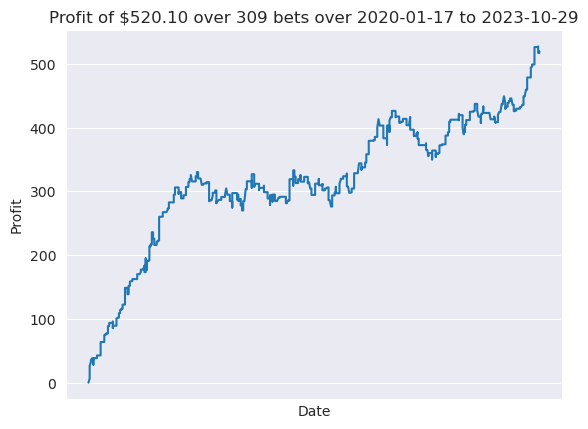

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

bets_placed = merged_df2['profit'].ne(0).sum()
profit = merged_df2['profit'].sum()
earliest_date = merged_df2['info_date'].min()
latest_date = merged_df2['info_date'].max()
sns.set_style('darkgrid')
plt.locator_params(axis='x', nbins=0)
plt.plot(merged_df2['info_date'], merged_df2['profit'].cumsum())
plt.xticks([])

plt.title(f'Profit of ${profit:.2f} over {bets_placed} bets over {earliest_date} to {latest_date}')
plt.xlabel('Date')
plt.ylabel('Profit')
plt.show()

In [94]:
# calculate profit margins for the model
bet_amount = 10
profit_margin = profit / (bets_placed * bet_amount) * 100
print(f'Profit margin: {profit_margin:.2f}%')

Profit margin: 16.83%
